In [1]:
import skimage
import numpy as np
import copy
import matplotlib.pyplot as plt
from tqdm import tqdm
from skimage import io
from skimage.draw import disk

In [2]:
np.random.seed(173)

In [3]:
def get_target_picture(name) :
    print("Target picture:")
    target_picture = io.imread(name)
    io.imshow(target_picture) 
    io.show()
    print("Shape: ", target_picture.shape)
    return target_picture

In [4]:
def put_image(board, image, position) :
    dx, dy = image.shape[0], image.shape[1]
    x, y = position[0], position[1]
    board[x:x + dx, y:y + dy, :] = image

In [5]:
def sim(img_a, img_b) :
    dif = img_a - img_b
    return np.sum(dif ** 2)

In [6]:
class tile() :
    
    color = (0, 0, 0)
    
    def init(self, col) :
        self.color = col
    
    def mutate_color(self, idx, shift) :
        self.color[idx] += np.random.randint(-shift, shift + 1)
        self.color = np.clip(self.color, 0, 255)
        
        

In [7]:
class individual() :
    
    N = 0
    size = 0
    tiles = []
    
    def init(self, _N, _size, tls) :
        self.N = _N
        self.size = _size
        self.tiles = tls
    
    def draw(self, tp) :
        X, Y = tp.shape[0], tp.shape[1]
        ret = np.zeros((X, Y, 3), dtype=int)
        pos_x = 0
        while(pos_x < X) :
            pos_y = 0
            while(pos_y < Y) :
                ret[pos_x:pos_x + self.size, pos_y:pos_y + self.size, :] = copy.deepcopy(self.tiles[0].color)
                pos_y += self.size
            pos_x += self.size
        for i in range(1, self.N) :
            col = copy.deepcopy(self.tiles[i].color)
            pos_x = 0
            while(pos_x < X) :
                pos_y = 0
                while(pos_y < Y) :
                    prev_col = copy.deepcopy(ret[pos_x][pos_y])
                    prev_local_fitness = sim(ret[pos_x:pos_x + self.size, pos_y:pos_y + self.size, :], tp[pos_x:pos_x + self.size, pos_y:pos_y + self.size, :])
                    ret[pos_x:pos_x + self.size, pos_y:pos_y + self.size, :] = col
                    cur_local_fitness = sim(ret[pos_x:pos_x + self.size, pos_y:pos_y + self.size, :], tp[pos_x:pos_x + self.size, pos_y:pos_y + self.size, :])
                    if(cur_local_fitness > prev_local_fitness) :
                        ret[pos_x:pos_x + self.size, pos_y:pos_y + self.size, :] = prev_col
                    pos_y += self.size
                pos_x += self.size
        return ret

In [8]:
def random_individual(N, tile_size) :
    tls = []
    for i in range(0, N) :
        cur_tile = tile()
        cur_tile.init(np.random.randint(0, 256, size = 3))
        tls.append(cur_tile)
    ret = individual()
    ret.init(N, tile_size, tls)
    return ret

In [9]:
def point_score(target_pic, ind) :
    return sim(ind.draw(target_pic), target_pic)

In [10]:
def run_ES(target_pic, save_pic = -1, save_path = "", number_of_tiles = 3, tile_size = 14, threshold1 = 5, threshold2 = 2, th1 = 2, th2 = 4, th3 = 10, rg1 = 50, rg2 = 20, rg3 = 10, init_population = 30, stay_alive = 15, steps = 300) :
    
    best = []
    best_fitness = int(1e18)
    population = []

    best_fitness_after_steps = np.zeros(steps + 1)
    best_pics = []
    
    for p in range(0, init_population) :
        ind = random_individual(number_of_tiles, tile_size)
        population.append(ind)

    population = np.array(population)
    
    for step in tqdm(range(0, steps + 1)) :
        
        children = copy.deepcopy(population)
        np.random.shuffle(children)
    
        L = len(population)
        for i in range(L) :
            ch = children[i]
            for ti in range(number_of_tiles) :
                if(np.random.randint(0, 2) == 0) :
                    ch.tiles[ti] = copy.deepcopy(population[i].tiles[ti])
                th = 0
                rg = 0
                if(step < steps / threshold1) :
                    th = th1
                    rg = rg1
                elif (step < steps / threshold2) :
                    th = th2
                    rg = rg2
                else :
                    th = th3
                    rg = rg3
                if(np.random.randint(0, th) == 0) :
                    ch.tiles[ti].mutate_color(np.random.randint(0, 3), rg)
    
        population = np.concatenate((population, children), axis=0)
        order = np.argsort([point_score(target_pic, x) for x in population], axis=0)
        population = population[order]
        population = population[0:stay_alive]
    
        if(point_score(target_pic, population[0]) < best_fitness) :
            best_fitness = point_score(target_pic, population[0])
            best = population[0]
        
        best_fitness_after_steps[step] = best_fitness
        
        if(save_pic != -1 and step % save_pic == 0) :
            print("Seps: ", step, "best_fitness: ", best_fitness)
            cur_path = save_path + str(step) + ".jpg"
            print("Saving to ", cur_path)
            pic = best.draw(target_pic)
            io.imsave(cur_path, pic) 
            
    return best_fitness_after_steps
    

In [11]:
def make_tests(tests, target, _number_of_tiles, _tile_size, _th1, _th2, _th3, _rg1, _rg2, _rg3, _steps = 300) :
    
    bfas = np.zeros(_steps + 1)
    
    for test in range(0, tests) :
        print("Test ", test + 1)
        results = run_ES(target_pic = target, number_of_tiles = _number_of_tiles, tile_size = _tile_size, th1 = _th1, th2 = _th2, th3 = _th3, rg1 = _rg1, rg2 = _rg2, rg3 = _rg3, steps = _steps)
        bfas += results
    
    bfas /= tests
    return bfas

In [12]:
TH3 = [0, 2, 4, 10]
RG3 = [0, 50, 20, 10]

TH8 = [0, 4, 8, 20]
RG8 = [0, 50, 20, 10]

TH15 = [0, 5, 10, 25]
RG15 = [0, 50, 20, 10]

Target picture:


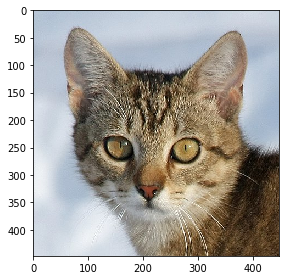

Shape:  (448, 448, 3)


  0%|                                                   | 0/301 [00:00<?, ?it/s]

Seps:  0 best_fitness:  680464878
Saving to  color-tiles/15col/kot0.jpg


/tmp/ipykernel_1897095/3482741245.py:57: UserWarning: color-tiles/15col/kot0.jpg is a low contrast image
  io.imsave(cur_path, pic)
Lossy conversion from int64 to uint8. Range [39, 240]. Convert image to uint8 prior to saving to suppress this warning.
  3%|█▍                                        | 10/301 [02:05<57:10, 11.79s/it]

Seps:  10 best_fitness:  504202390
Saving to  color-tiles/15col/kot10.jpg


/tmp/ipykernel_1897095/3482741245.py:57: UserWarning: color-tiles/15col/kot10.jpg is a low contrast image
  io.imsave(cur_path, pic)
Lossy conversion from int64 to uint8. Range [34, 254]. Convert image to uint8 prior to saving to suppress this warning.
  7%|██▋                                     | 20/301 [04:27<1:01:01, 13.03s/it]

Seps:  20 best_fitness:  468511922
Saving to  color-tiles/15col/kot20.jpg


/tmp/ipykernel_1897095/3482741245.py:57: UserWarning: color-tiles/15col/kot20.jpg is a low contrast image
  io.imsave(cur_path, pic)
Lossy conversion from int64 to uint8. Range [4, 254]. Convert image to uint8 prior to saving to suppress this warning.
 10%|███▉                                    | 30/301 [07:30<1:15:55, 16.81s/it]

Seps:  30 best_fitness:  418261096
Saving to  color-tiles/15col/kot30.jpg


/tmp/ipykernel_1897095/3482741245.py:57: UserWarning: color-tiles/15col/kot30.jpg is a low contrast image
  io.imsave(cur_path, pic)
Lossy conversion from int64 to uint8. Range [12, 233]. Convert image to uint8 prior to saving to suppress this warning.
 13%|█████▎                                  | 40/301 [10:55<1:32:55, 21.36s/it]

Seps:  40 best_fitness:  410685816
Saving to  color-tiles/15col/kot40.jpg


/tmp/ipykernel_1897095/3482741245.py:57: UserWarning: color-tiles/15col/kot40.jpg is a low contrast image
  io.imsave(cur_path, pic)
Lossy conversion from int64 to uint8. Range [34, 233]. Convert image to uint8 prior to saving to suppress this warning.
 17%|██████▋                                 | 50/301 [14:14<1:19:07, 18.91s/it]

Seps:  50 best_fitness:  405704346
Saving to  color-tiles/15col/kot50.jpg


/tmp/ipykernel_1897095/3482741245.py:57: UserWarning: color-tiles/15col/kot50.jpg is a low contrast image
  io.imsave(cur_path, pic)
Lossy conversion from int64 to uint8. Range [12, 233]. Convert image to uint8 prior to saving to suppress this warning.
 20%|███████▉                                | 60/301 [16:52<1:02:35, 15.58s/it]

Seps:  60 best_fitness:  395007450
Saving to  color-tiles/15col/kot60.jpg


/tmp/ipykernel_1897095/3482741245.py:57: UserWarning: color-tiles/15col/kot60.jpg is a low contrast image
  io.imsave(cur_path, pic)
Lossy conversion from int64 to uint8. Range [12, 233]. Convert image to uint8 prior to saving to suppress this warning.
 23%|█████████▊                                | 70/301 [18:59<50:39, 13.16s/it]

Seps:  70 best_fitness:  387998988
Saving to  color-tiles/15col/kot70.jpg


/tmp/ipykernel_1897095/3482741245.py:57: UserWarning: color-tiles/15col/kot70.jpg is a low contrast image
  io.imsave(cur_path, pic)
Lossy conversion from int64 to uint8. Range [12, 229]. Convert image to uint8 prior to saving to suppress this warning.
 27%|███████████▏                              | 80/301 [21:20<54:25, 14.78s/it]

Seps:  80 best_fitness:  384031588
Saving to  color-tiles/15col/kot80.jpg


/tmp/ipykernel_1897095/3482741245.py:57: UserWarning: color-tiles/15col/kot80.jpg is a low contrast image
  io.imsave(cur_path, pic)
Lossy conversion from int64 to uint8. Range [18, 229]. Convert image to uint8 prior to saving to suppress this warning.
 30%|███████████▉                            | 90/301 [24:43<1:13:15, 20.83s/it]

Seps:  90 best_fitness:  380048080
Saving to  color-tiles/15col/kot90.jpg


/tmp/ipykernel_1897095/3482741245.py:57: UserWarning: color-tiles/15col/kot90.jpg is a low contrast image
  io.imsave(cur_path, pic)
Lossy conversion from int64 to uint8. Range [18, 229]. Convert image to uint8 prior to saving to suppress this warning.
 33%|████████████▉                          | 100/301 [28:06<1:07:10, 20.05s/it]

Seps:  100 best_fitness:  378412432
Saving to  color-tiles/15col/kot100.jpg


/tmp/ipykernel_1897095/3482741245.py:57: UserWarning: color-tiles/15col/kot100.jpg is a low contrast image
  io.imsave(cur_path, pic)
Lossy conversion from int64 to uint8. Range [18, 229]. Convert image to uint8 prior to saving to suppress this warning.
 37%|██████████████▉                          | 110/301 [30:37<43:26, 13.65s/it]

Seps:  110 best_fitness:  377178572
Saving to  color-tiles/15col/kot110.jpg


/tmp/ipykernel_1897095/3482741245.py:57: UserWarning: color-tiles/15col/kot110.jpg is a low contrast image
  io.imsave(cur_path, pic)
Lossy conversion from int64 to uint8. Range [18, 229]. Convert image to uint8 prior to saving to suppress this warning.
 40%|████████████████▎                        | 120/301 [33:31<50:46, 16.83s/it]

Seps:  120 best_fitness:  376466246
Saving to  color-tiles/15col/kot120.jpg


/tmp/ipykernel_1897095/3482741245.py:57: UserWarning: color-tiles/15col/kot120.jpg is a low contrast image
  io.imsave(cur_path, pic)
Lossy conversion from int64 to uint8. Range [18, 229]. Convert image to uint8 prior to saving to suppress this warning.
 43%|█████████████████▋                       | 130/301 [36:11<46:23, 16.28s/it]

Seps:  130 best_fitness:  374734584
Saving to  color-tiles/15col/kot130.jpg


/tmp/ipykernel_1897095/3482741245.py:57: UserWarning: color-tiles/15col/kot130.jpg is a low contrast image
  io.imsave(cur_path, pic)
Lossy conversion from int64 to uint8. Range [18, 229]. Convert image to uint8 prior to saving to suppress this warning.
 47%|███████████████████                      | 140/301 [39:13<46:35, 17.36s/it]

Seps:  140 best_fitness:  373897522
Saving to  color-tiles/15col/kot140.jpg


/tmp/ipykernel_1897095/3482741245.py:57: UserWarning: color-tiles/15col/kot140.jpg is a low contrast image
  io.imsave(cur_path, pic)
Lossy conversion from int64 to uint8. Range [18, 229]. Convert image to uint8 prior to saving to suppress this warning.
 50%|████████████████████▍                    | 150/301 [41:38<31:48, 12.64s/it]

Seps:  150 best_fitness:  373533744
Saving to  color-tiles/15col/kot150.jpg


/tmp/ipykernel_1897095/3482741245.py:57: UserWarning: color-tiles/15col/kot150.jpg is a low contrast image
  io.imsave(cur_path, pic)
Lossy conversion from int64 to uint8. Range [18, 229]. Convert image to uint8 prior to saving to suppress this warning.
 53%|█████████████████████▊                   | 160/301 [44:39<45:56, 19.55s/it]

Seps:  160 best_fitness:  372902984
Saving to  color-tiles/15col/kot160.jpg


/tmp/ipykernel_1897095/3482741245.py:57: UserWarning: color-tiles/15col/kot160.jpg is a low contrast image
  io.imsave(cur_path, pic)
Lossy conversion from int64 to uint8. Range [18, 229]. Convert image to uint8 prior to saving to suppress this warning.
 56%|███████████████████████▏                 | 170/301 [47:48<41:45, 19.13s/it]

Seps:  170 best_fitness:  372346522
Saving to  color-tiles/15col/kot170.jpg


/tmp/ipykernel_1897095/3482741245.py:57: UserWarning: color-tiles/15col/kot170.jpg is a low contrast image
  io.imsave(cur_path, pic)
Lossy conversion from int64 to uint8. Range [20, 229]. Convert image to uint8 prior to saving to suppress this warning.
 60%|████████████████████████▌                | 180/301 [50:41<36:50, 18.27s/it]

Seps:  180 best_fitness:  371802210
Saving to  color-tiles/15col/kot180.jpg


/tmp/ipykernel_1897095/3482741245.py:57: UserWarning: color-tiles/15col/kot180.jpg is a low contrast image
  io.imsave(cur_path, pic)
Lossy conversion from int64 to uint8. Range [20, 229]. Convert image to uint8 prior to saving to suppress this warning.
 63%|█████████████████████████▉               | 190/301 [53:16<28:00, 15.14s/it]

Seps:  190 best_fitness:  371366584
Saving to  color-tiles/15col/kot190.jpg


/tmp/ipykernel_1897095/3482741245.py:57: UserWarning: color-tiles/15col/kot190.jpg is a low contrast image
  io.imsave(cur_path, pic)
Lossy conversion from int64 to uint8. Range [20, 229]. Convert image to uint8 prior to saving to suppress this warning.
 66%|███████████████████████████▏             | 200/301 [56:40<33:07, 19.67s/it]

Seps:  200 best_fitness:  371181994
Saving to  color-tiles/15col/kot200.jpg


/tmp/ipykernel_1897095/3482741245.py:57: UserWarning: color-tiles/15col/kot200.jpg is a low contrast image
  io.imsave(cur_path, pic)
Lossy conversion from int64 to uint8. Range [20, 229]. Convert image to uint8 prior to saving to suppress this warning.
 70%|████████████████████████████▌            | 210/301 [59:49<23:48, 15.69s/it]

Seps:  210 best_fitness:  370994038
Saving to  color-tiles/15col/kot210.jpg


/tmp/ipykernel_1897095/3482741245.py:57: UserWarning: color-tiles/15col/kot210.jpg is a low contrast image
  io.imsave(cur_path, pic)
Lossy conversion from int64 to uint8. Range [20, 229]. Convert image to uint8 prior to saving to suppress this warning.
 73%|████████████████████████████▌          | 220/301 [1:02:43<21:16, 15.75s/it]

Seps:  220 best_fitness:  370683662
Saving to  color-tiles/15col/kot220.jpg


/tmp/ipykernel_1897095/3482741245.py:57: UserWarning: color-tiles/15col/kot220.jpg is a low contrast image
  io.imsave(cur_path, pic)
Lossy conversion from int64 to uint8. Range [20, 229]. Convert image to uint8 prior to saving to suppress this warning.
 76%|█████████████████████████████▊         | 230/301 [1:06:03<23:12, 19.62s/it]

Seps:  230 best_fitness:  370627256
Saving to  color-tiles/15col/kot230.jpg


/tmp/ipykernel_1897095/3482741245.py:57: UserWarning: color-tiles/15col/kot230.jpg is a low contrast image
  io.imsave(cur_path, pic)
Lossy conversion from int64 to uint8. Range [20, 229]. Convert image to uint8 prior to saving to suppress this warning.
 80%|███████████████████████████████        | 240/301 [1:08:48<16:23, 16.12s/it]

Seps:  240 best_fitness:  370530838
Saving to  color-tiles/15col/kot240.jpg


/tmp/ipykernel_1897095/3482741245.py:57: UserWarning: color-tiles/15col/kot240.jpg is a low contrast image
  io.imsave(cur_path, pic)
Lossy conversion from int64 to uint8. Range [20, 226]. Convert image to uint8 prior to saving to suppress this warning.
 83%|████████████████████████████████▍      | 250/301 [1:11:37<16:00, 18.84s/it]

Seps:  250 best_fitness:  370486148
Saving to  color-tiles/15col/kot250.jpg


/tmp/ipykernel_1897095/3482741245.py:57: UserWarning: color-tiles/15col/kot250.jpg is a low contrast image
  io.imsave(cur_path, pic)
Lossy conversion from int64 to uint8. Range [20, 226]. Convert image to uint8 prior to saving to suppress this warning.
 86%|█████████████████████████████████▋     | 260/301 [1:13:47<08:30, 12.46s/it]

Seps:  260 best_fitness:  370461788
Saving to  color-tiles/15col/kot260.jpg


/tmp/ipykernel_1897095/3482741245.py:57: UserWarning: color-tiles/15col/kot260.jpg is a low contrast image
  io.imsave(cur_path, pic)
Lossy conversion from int64 to uint8. Range [20, 226]. Convert image to uint8 prior to saving to suppress this warning.
 90%|██████████████████████████████████▉    | 270/301 [1:16:01<06:14, 12.09s/it]

Seps:  270 best_fitness:  370436216
Saving to  color-tiles/15col/kot270.jpg


/tmp/ipykernel_1897095/3482741245.py:57: UserWarning: color-tiles/15col/kot270.jpg is a low contrast image
  io.imsave(cur_path, pic)
Lossy conversion from int64 to uint8. Range [21, 226]. Convert image to uint8 prior to saving to suppress this warning.
 93%|████████████████████████████████████▎  | 280/301 [1:17:50<03:50, 10.96s/it]

Seps:  280 best_fitness:  370358910
Saving to  color-tiles/15col/kot280.jpg


/tmp/ipykernel_1897095/3482741245.py:57: UserWarning: color-tiles/15col/kot280.jpg is a low contrast image
  io.imsave(cur_path, pic)
Lossy conversion from int64 to uint8. Range [21, 226]. Convert image to uint8 prior to saving to suppress this warning.
 96%|█████████████████████████████████████▌ | 290/301 [1:19:39<02:00, 10.93s/it]

Seps:  290 best_fitness:  370358910
Saving to  color-tiles/15col/kot290.jpg


/tmp/ipykernel_1897095/3482741245.py:57: UserWarning: color-tiles/15col/kot290.jpg is a low contrast image
  io.imsave(cur_path, pic)
Lossy conversion from int64 to uint8. Range [21, 226]. Convert image to uint8 prior to saving to suppress this warning.
100%|██████████████████████████████████████▊| 300/301 [1:21:28<00:10, 10.90s/it]

Seps:  300 best_fitness:  370298330
Saving to  color-tiles/15col/kot300.jpg


/tmp/ipykernel_1897095/3482741245.py:57: UserWarning: color-tiles/15col/kot300.jpg is a low contrast image
  io.imsave(cur_path, pic)
Lossy conversion from int64 to uint8. Range [21, 226]. Convert image to uint8 prior to saving to suppress this warning.
100%|███████████████████████████████████████| 301/301 [1:21:39<00:00, 16.28s/it]


array([6.80464878e+08, 6.66980962e+08, 6.29286328e+08, 6.29286328e+08,
       5.74821324e+08, 5.74821324e+08, 5.57732396e+08, 5.07746874e+08,
       5.07746874e+08, 5.04202390e+08, 5.04202390e+08, 5.04202390e+08,
       4.96966850e+08, 4.96966850e+08, 4.76959230e+08, 4.76959230e+08,
       4.76959230e+08, 4.68511922e+08, 4.68511922e+08, 4.68511922e+08,
       4.68511922e+08, 4.65028334e+08, 4.65028334e+08, 4.56299886e+08,
       4.49342928e+08, 4.49342928e+08, 4.49342928e+08, 4.41355676e+08,
       4.41258040e+08, 4.31236386e+08, 4.18261096e+08, 4.18261096e+08,
       4.18261096e+08, 4.18261096e+08, 4.18261096e+08, 4.18261096e+08,
       4.18261096e+08, 4.12986116e+08, 4.12986116e+08, 4.10685816e+08,
       4.10685816e+08, 4.10685816e+08, 4.10685816e+08, 4.09320468e+08,
       4.09320468e+08, 4.09320468e+08, 4.05704346e+08, 4.05704346e+08,
       4.05704346e+08, 4.05704346e+08, 4.05704346e+08, 4.05704346e+08,
       4.05704346e+08, 4.05704346e+08, 4.03664454e+08, 4.03664454e+08,
      

In [13]:
cur_target = get_target_picture('kot_square.jpg')
run_ES(target_pic = cur_target, save_pic = 10, save_path = 'color-tiles/15col/kot', number_of_tiles = 15, tile_size = 14, th1 = TH15[1], th2 = TH15[2], th3 = TH15[3], rg1 = RG15[1], rg2 = RG15[2], rg3 = RG15[3])

In [14]:
data = make_tests(tests = 5, target = cur_target, _number_of_tiles = 15, _tile_size = 14, _th1 = TH15[1], _th2 = TH15[2], _th3 = TH15[3], _rg1 = RG15[1], _rg2 = RG15[2], _rg3 = RG15[3])

Test  1


100%|███████████████████████████████████████| 301/301 [1:17:14<00:00, 15.40s/it]


Test  2


100%|███████████████████████████████████████| 301/301 [1:17:04<00:00, 15.36s/it]


Test  3


100%|███████████████████████████████████████| 301/301 [1:16:47<00:00, 15.31s/it]


Test  4


100%|█████████████████████████████████████████| 301/301 [57:36<00:00, 11.48s/it]


Test  5


100%|█████████████████████████████████████████| 301/301 [53:13<00:00, 10.61s/it]


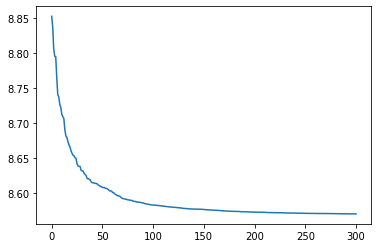

In [15]:
plt.figure()
plt.plot(np.log10(data))
plt.show()

In [16]:
file_to_save = open("color-tiles/15col/col15kot.txt", "w")
np.savetxt(file_to_save, data)
file_to_save.close()